In [49]:
from numpy import array
import numpy as np
import keras
import tensorflow
# from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization,LSTM

from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
import pandas as pd

from math import log
from math import exp
from scipy.stats import boxcox
import matplotlib.pyplot as plt



In [50]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [51]:
def invert_boxcox(value, lam):
	# log case
	if lam == 0:
		return exp(value)
	# all other cases
	return exp(log(lam * value + 1) / lam)

In [52]:

data = pd.read_excel("New data.xlsx")

t = data.iloc[0:204] #11565
v = data.iloc[204:228]
ts = data.iloc[228:252]

train_seq = t['Nam Định'].values
epsilon = 1e-10
train_seq = train_seq + epsilon   
val_seq = v['Nam Định'].values
test_seq = ts['Nam Định'].values
tr, tr_lamb = boxcox(train_seq)
vl, vl_lamb = boxcox(val_seq)
ts, ts_lamb = boxcox(test_seq)

print('Training Sequence : %d'%len(train_seq))
print('Validation Sequence : %d'%len(val_seq))
print('Testing Sequence : %d'%len(test_seq))
print(test_seq)

Training Sequence : 204
Validation Sequence : 24
Testing Sequence : 24
[5.000e-01 3.930e+01 2.710e+01 1.488e+02 1.959e+02 2.238e+02 3.557e+02
 1.482e+02 7.132e+02 3.244e+02 4.740e+01 3.000e+00 8.810e+01 1.011e+02
 6.270e+01 1.022e+02 1.722e+02 1.362e+02 3.290e+02 5.150e+02 6.530e+02
 2.852e+02 8.700e+01 1.070e+01]


In [53]:
n_steps_in, n_steps_out = 12, 12
# split into samples

X_train = np.log(train_seq) 
X_test = np.log(test_seq)
# print(X_test)
X_train, y_train = split_sequence(tr, n_steps_in, n_steps_out)
X_val, y_val = split_sequence(vl, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(ts, n_steps_in, n_steps_out)

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], n_steps_in, n_features))
X_val = X_val.reshape((X_val.shape[0], n_steps_in, n_features))
X_test = X_test.reshape((X_test.shape[0], n_steps_in, n_features))
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)




X_train shape: (181, 12, 1)
X_val shape: (1, 12, 1)
X_test shape: (1, 12, 1)


In [54]:
import keras.backend as kb

def r2_score(y_true, y_pred):
    ss_res = kb.sum(kb.square(y_true - y_pred))
    ss_tot = kb.sum(kb.square(y_true - kb.mean(y_true)))
    return (1 - ss_res/(ss_tot + kb.epsilon()))

# model = Sequential()
# # Additional convolutional layer 
# model.add(Conv1D(filters=256, kernel_size=5, activation='relu', input_shape=(n_steps_in, n_features)))
# model.add(Conv1D(filters=128, kernel_size=3, activation='relu')) 
# # BatchNorm for stability
# model.add(BatchNormalization())
# model.add(MaxPooling1D(pool_size=2))
# # Lower dropout 
# model.add(Dropout(0.1))

# # LSTM layer to learn longer sequences
# model.add(LSTM(128))  

# model.add(Dropout(0.1))

# # Larger dense layers
# model.add(Dense(256, activation='relu'))
# model.add(Dense(n_steps_out))


# Compile with different optimizer
# model.compile(optimizer=RMSprop(), loss='mse')
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=5, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(n_steps_in, n_features), kernel_regularizer=keras.regularizers.l2(l=0.01), kernel_initializer='he_normal'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), kernel_initializer='he_normal'))
model.add(Dense(n_steps_out, activation ='relu'))

adam = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer='adam', loss='mse')
            #   metrics=[r2_score, 'mae', keras.metrics.RootMeanSquaredError()])
# model = Sequential()
# model.add(Conv1D(filters=126, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features), kernel_regularizer=keras.regularizers.l2(l=0.01), kernel_initializer='he_normal'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Flatten())
# model.add(Dropout(0.2))
# model.add(Dense(n_steps_out))

# adam = keras.optimizers.Adam(lr=0.001)
# model.compile(optimizer=adam, loss='mse', metrics=[r2_score, 'mae', keras.metrics.RootMeanSquaredError()])

In [55]:
history = model.fit(X_train, y_train, epochs=200, verbose=1, validation_data=(X_val, y_val), batch_size=64)


Epoch 1/200


3/3 [==============================] - 1s 97ms/step - loss: 76.5192 - val_loss: 47.6645
Epoch 2/200
3/3 [==============================] - 0s 24ms/step - loss: 50.0024 - val_loss: 42.3716
Epoch 3/200
3/3 [==============================] - 0s 23ms/step - loss: 46.5307 - val_loss: 38.1671
Epoch 4/200
3/3 [==============================] - 0s 22ms/step - loss: 38.5835 - val_loss: 30.3176
Epoch 5/200
3/3 [==============================] - 0s 20ms/step - loss: 35.1836 - val_loss: 26.1572
Epoch 6/200
3/3 [==============================] - 0s 24ms/step - loss: 32.7371 - val_loss: 19.6384
Epoch 7/200
3/3 [==============================] - 0s 26ms/step - loss: 29.0239 - val_loss: 13.2608
Epoch 8/200
3/3 [==============================] - 0s 24ms/step - loss: 26.1168 - val_loss: 11.5017
Epoch 9/200
3/3 [==============================] - 0s 25ms/step - loss: 23.6904 - val_loss: 12.2899
Epoch 10/200
3/3 [==============================] - 0s 23ms/step - loss: 21.7149 - val_loss: 13.7100
Epoch 11/20

In [ ]:


from tensorflow.keras.utils import plot_model
plot_model(model, to_file=r'C:\Users\user\Documents\GitHub\Deep_Learning_Rainfall\CNN\CNN metrics\Structure model.png', show_shapes=True, show_layer_names=True)
# print(model) 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 8, 256)            1536      
                                                                 
 conv1d_3 (Conv1D)           (None, 6, 128)            98432     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 3, 128)            0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 384)               0         
                                                                 
 dropout_1 (Dropout)         (None, 384)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               49280     
                                                      

In [ ]:
hist_df = pd.DataFrame(history.history) 
# hist_csv_file = r'C:\Users\user\Documents\GitHub\Deep_Learning_Rainfall\CNN\CNN metrics\history.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

In [ ]:
prediction = model.predict(X_test, verbose=0)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
mae = mean_absolute_error(prediction, y_test)
mse = mean_squared_error(prediction, y_test)
r2 = r2_score(prediction[0], y_test[0])
rmse = np.sqrt(mse)
print('Predicted MSE : %s'%mse)
print('Predicted R2 Score : %s'%r2)
print('Predicted RMSE  : %s'%rmse)
print('Predicted MAE : %s'%mae)
# RMSE
# MAE


Predicted MSE : 6.679495665465708
Predicted R2 Score : 0.7214078268962942
Predicted RMSE  : 2.5844720283775
Predicted MAE : 2.1416943858926905


In [ ]:
y_test[0]
# prediction[0]

array([10.42932131, 11.06401296,  8.98130068, 11.11517081, 13.81595258,
       12.54313001, 17.89776144, 21.29069239, 23.30640901, 16.91912588,
       10.37283194,  3.62422643])

In [ ]:
x = np.arange(12)
y_test_invert = []

# Inverse Box-Cox Transform
for i in range(len(y_test[0])):
    y_test_invert.append(invert_boxcox(y_test[0][i], ts_lamb))


In [ ]:
x = np.arange(12)
y_prediction_invert = []

# Inverse Box-Cox Transform
for i in range(len(y_test[0])):
    y_prediction_invert.append(invert_boxcox(prediction[0][i], ts_lamb))


In [ ]:
y_prediction_invert

[31.074418608311078,
 58.48988710161914,
 44.35627222886014,
 98.67326255859886,
 185.1533474104407,
 245.23397860450322,
 373.58853228236023,
 487.60443708969206,
 388.9782410102701,
 160.27398512751859,
 60.074278241149564,
 37.69724455418573]

In [ ]:
y_test_invert

[88.10000000000001,
 101.1,
 62.7,
 102.19999999999999,
 172.19999999999993,
 136.19999999999993,
 329.0,
 515.0000000000006,
 653.0,
 285.2,
 87.0,
 10.699999999999998]

In [ ]:

df = pd.DataFrame({'Actual': y_test_invert, 'Predicted': y_prediction_invert})

# Display the DataFrame
print(df)








    Actual   Predicted
0     88.1   31.074419
1    101.1   58.489887
2     62.7   44.356272
3    102.2   98.673263
4    172.2  185.153347
5    136.2  245.233979
6    329.0  373.588532
7    515.0  487.604437
8    653.0  388.978241
9    285.2  160.273985
10    87.0   60.074278
11    10.7   37.697245


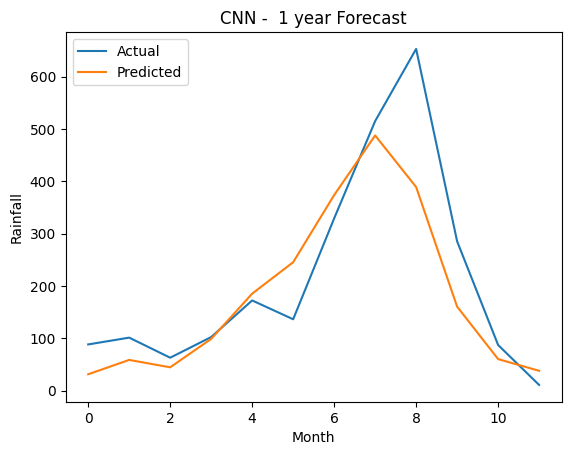

In [ ]:
plt.plot(y_test_invert)
plt.plot(y_prediction_invert)
plt.title('CNN -  1 year Forecast')
plt.ylabel('Rainfall')
plt.xlabel('Month')
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.savefig(r'C:\Users\user\Documents\GitHub\Deep_Learning_Rainfall\CNN\CNN metrics\plot_test.png')
plt.show()

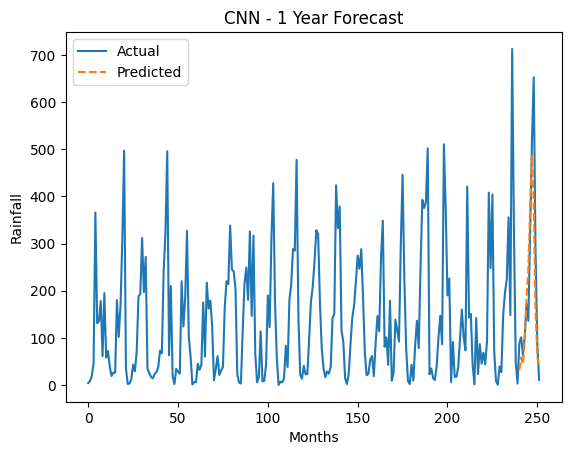

In [ ]:

import numpy as np

# Assuming data is a DataFrame and has a column "Bãi Cháy" with actual values
actual_values = data["Nam Định"].values

# Assuming y_prediction_invert is your predicted values
predicted_values = y_prediction_invert

# Number of data points for actual values
num_data_points_actual = len(actual_values)

# Number of data points for predicted values
num_data_points_predicted = len(predicted_values)

# Generate x-axis values for the entire dataset
x_values_actual = np.arange(num_data_points_actual)
x_values_predicted = np.arange(num_data_points_actual - num_data_points_predicted, num_data_points_actual)

# Plotting
plt.plot(x_values_actual, actual_values, label='Actual')
plt.plot(x_values_predicted, predicted_values, label='Predicted', linestyle='dashed')
plt.title('CNN - 1 Year Forecast')
plt.ylabel('Rainfall')
plt.xlabel('Months')
plt.legend()
plt.savefig(r'C:\Users\user\Documents\GitHub\Deep_Learning_Rainfall\CNN\CNN metrics\comparison.png')
plt.show()
